# Building a Discord Post Classifier using SVM

Launch a DSEG moderator bot in discord that helps members post in the right channel. The bot will detect if a member has posted in the correct channel. If it finds that the post is in the wrong channel, it will suggest a correct channel from among the channels in the Community or Help categories. The bot will be active in discord for one week after project deadline, but can stay alive if members like it.

## Acceptance Criteria

For the bot to be enabled in DSEG, it must meet the threshold of 5% false positives on detecting posts in the wrong channel and 90% accuracy in suggesting the correct channel. A test dataset of 50 utterances has been withheld and will be used to evaluate your project upon submission. The test dataset has 3 fields: utterance, guessed-channel, true-channel. Your bot (or model) must determine if guessed channel is false with 95% specificity, and identify the true channel with 90% accuracy. There will be a leaderboard showing the performance rankings of all participants.

## Datasets

In this repo is utterance-channel-dataset.csv, a dataset consisting of 300 posts and the corresponding appropriate channel for each post.

## Plan

The plan is to preprocess your text data using TF-IDF (NLP), build a classifier using an SVM (ML), run your code in a Jupyter notebook, and leverage functions from SKLearn. Resources are available below to explain all the above concepts. If you have the time and motivation, a good challenge is to implement SVMs with stochastic gradient descent from scratch. If there is time permitting build a Flask, run it in AWS, use the Discord API, and deploy your moderator bot in our server. Keep in mind that at the halfway point and at completion you will present your work to the community. Make sure to have some progress and work to show at each point to stay accountable and to provide teaching for more novice members of the community.

## Methodology

### Loading the dataset and initial EDA

In [1]:
# Importing libraries
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import regex as re
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# Saving the CSV dataset to a pandas DF
df = pd.read_csv('data/utterance-channel-dataset.csv')

In [3]:
df.shape

(300, 3)

In [4]:
df.head(10)

,Utterance,Channel,ID
0,Separate Category for the Weekly Topic To bett...,community-requests,1
1,"hey, i would like to ask if it's possible to g...",community-requests,2
2,Any update on my ModMail about the hackathon?,community-requests,3
3,@Admins I have a suggestion. Python has some m...,community-requests,4
4,Can we have a beginner channel,community-requests,5
5,Channel Rename We've changed #async-and-concur...,community-requests,6
6,FAQ Update We've updated the Frequently Asked ...,community-requests,7
7,February data review We've published our Febru...,community-requests,8
8,Food names We've changed the names of our help...,community-requests,9
9,"Hey, I see you asked in #python-general. Pytho...",community-requests,10


In [5]:
df['Channel'].value_counts()

Off-topic                   61
general-questions           42
community-requests          40
member-generated-content    39
Introduction                35
Resources                   35
Resume Review               25
General                     23
Name: Channel, dtype: int64

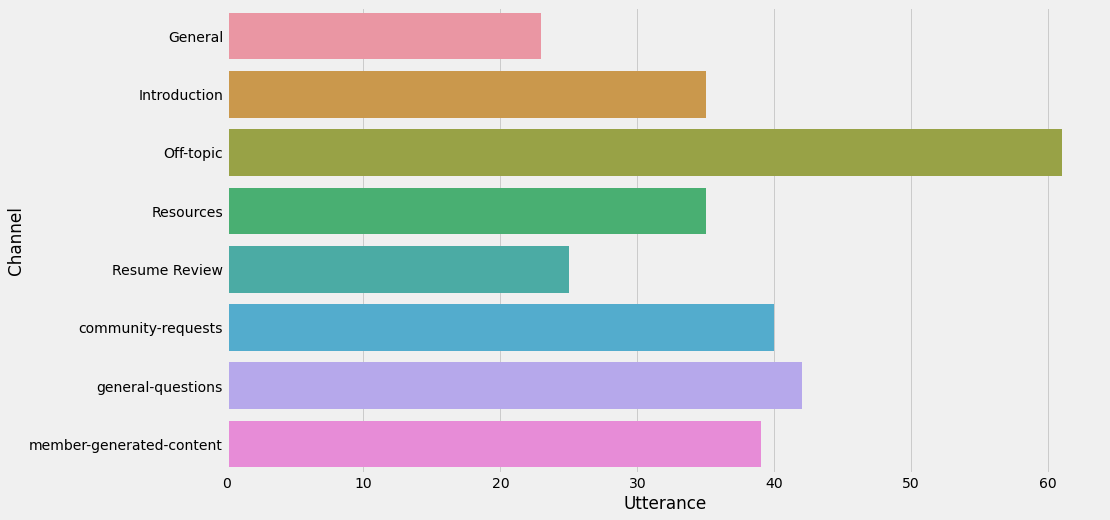

In [6]:
# Visualizing proportion of posts in the DF
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14,8))

df_2 = df.groupby('Channel').count()
df_2.reset_index(inplace=True)
sns.barplot(x='Utterance', y='Channel', data=df_2);

## Building the SVM Model 

### SVM with TF-IDF'ed features

In [7]:
df.head(3)

,Utterance,Channel,ID
0,Separate Category for the Weekly Topic To bett...,community-requests,1
1,"hey, i would like to ask if it's possible to g...",community-requests,2
2,Any update on my ModMail about the hackathon?,community-requests,3


Baseline model performance using data that is not preprocessed and default parameters of svm.LinearSVC

In [8]:
### must meet the threshold of 5% false positives on detecting posts in the wrong channel and 90% accuracy in suggesting the correct channel

# Splitting the values into testing and training data 
X_train, X_test, y_train, y_test= train_test_split(df["Utterance"],
                                                    df["Channel"],
                                                    test_size = 0.30, 
                                                    stratify = df["Channel"],random_state=17) #preserve the distribution and enable reproducibility

## Using tfidf Vectorizer and sklearn.svm.LinearSVC
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train_x = vectorizer.fit_transform(X_train)
classifier = LinearSVC()
classifier.fit(tfidf_train_x.toarray(), y_train)
tfidf_test_x = vectorizer.transform(X_test) #applying tf-idf to the test data
print(tfidf_test_x.shape)
scores = cross_val_score(classifier, tfidf_test_x.toarray(), y_test, cv=5) #cross-validation
acc = scores.mean()
print("Accuracy: %0.2f percent" % (acc *100))


(90, 1435)
Accuracy: 56.67 percent


In [9]:
predictions = classifier.predict(tfidf_test_x.toarray())

In [10]:
# Generate classification report
pd.DataFrame(classification_report(y_test,predictions,output_dict=True))

,General,Introduction,Off-topic,Resources,Resume Review,community-requests,general-questions,member-generated-content,accuracy,macro avg,weighted avg
precision,0.714286,0.7,0.680000,0.545455,1.000000,0.800000,0.666667,1.0,0.733333,0.763301,0.750074
recall,0.714286,0.7,0.944444,0.545455,0.428571,0.666667,0.615385,1.0,0.733333,0.701851,0.733333
f1-score,0.714286,0.7,0.790698,0.545455,0.600000,0.727273,0.640000,1.0,0.733333,0.714714,0.727554
support,7.000000,10.0,18.000000,11.000000,7.000000,12.000000,13.000000,12.0,0.733333,90.000000,90.000000


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

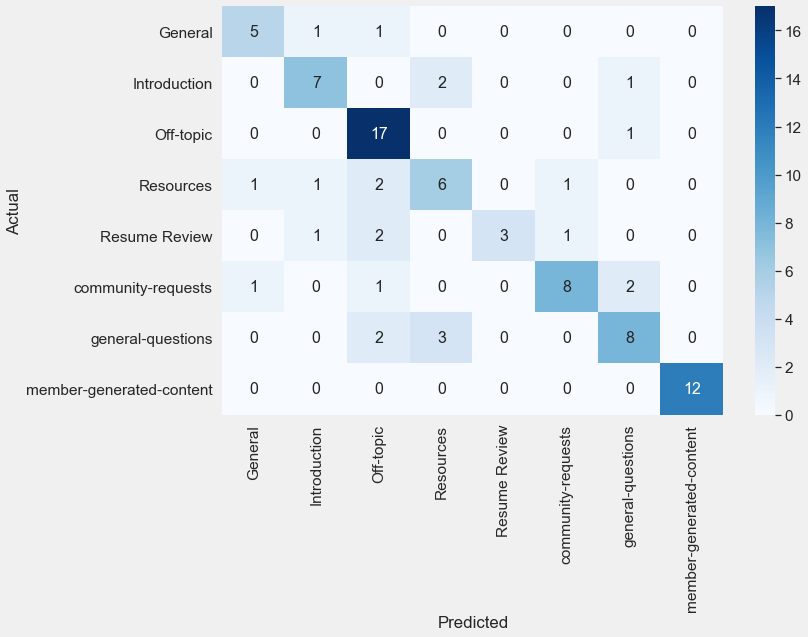

In [11]:
# Plotting the confusion matrix
data = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [12]:
# Using OnevsRest Classifier LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC()).fit(tfidf_train_x.toarray(), y_train)


scores = cross_val_score(clf, tfidf_test_x.toarray(), y_test, cv=5) #cross-validation
acc = scores.mean()
print("Accuracy: %0.2f percent" % (acc *100))

Accuracy: 58.89 percent


In [13]:
predictions = clf.predict(tfidf_test_x.toarray())
pd.DataFrame(classification_report(y_test,predictions,output_dict=True))

,General,Introduction,Off-topic,Resources,Resume Review,community-requests,general-questions,member-generated-content,accuracy,macro avg,weighted avg
precision,0.714286,0.7,0.5625,0.636364,1.000000,0.857143,0.777778,1.000000,0.711111,0.781009,0.761354
recall,0.714286,0.7,1.0000,0.636364,0.428571,0.500000,0.538462,0.916667,0.711111,0.679294,0.711111
f1-score,0.714286,0.7,0.7200,0.636364,0.600000,0.631579,0.636364,0.956522,0.711111,0.699389,0.705444
support,7.000000,10.0,18.0000,11.000000,7.000000,12.000000,13.000000,12.000000,0.711111,90.000000,90.000000


### Lemmatized Words + TF IDF Vectorizer

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

# Download stopwords list
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

# Interface lemma tokenizer from nltk with sklearn
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

# Lemmatize the stop words
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

# Splitting the values into testing and training data 
X_train, X_test, y_train, y_test= train_test_split(df["Utterance"],
                                                    df["Channel"],
                                                    test_size = 0.30, 
                                                    stratify = df["Channel"],random_state=17) #preserve the distribution and enable reproducibility
# Create TF-idf model
vectorizer = TfidfVectorizer(stop_words=token_stop, 
                              tokenizer=tokenizer)

tfidf_train_x = vectorizer.fit_transform(X_train)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
classifier = LinearSVC()
classifier.fit(tfidf_train_x.toarray(), y_train)
tfidf_test_x = vectorizer.transform(X_test) #applying tf-idf to the test data
scores = cross_val_score(classifier, tfidf_test_x.toarray(), y_test, cv=5) #cross-validation
acc = scores.mean()
print("Accuracy: %0.2f percent" % (acc *100))

Accuracy: 57.78 percent


In [16]:
predictions = classifier.predict(tfidf_test_x.toarray())
pd.DataFrame(classification_report(y_test,predictions,output_dict=True))

,General,Introduction,Off-topic,Resources,Resume Review,community-requests,general-questions,member-generated-content,accuracy,macro avg,weighted avg
precision,0.750000,0.666667,0.652174,0.615385,1.000000,0.75,0.700000,1.000000,0.722222,0.766778,0.750278
recall,0.857143,0.800000,0.833333,0.727273,0.142857,0.75,0.538462,0.916667,0.722222,0.695717,0.722222
f1-score,0.800000,0.727273,0.731707,0.666667,0.250000,0.75,0.608696,0.956522,0.722222,0.686358,0.705757
support,7.000000,10.000000,18.000000,11.000000,7.000000,12.00,13.000000,12.000000,0.722222,90.000000,90.000000


In [17]:
clf = OneVsRestClassifier(SVC()).fit(tfidf_train_x.toarray(), y_train)

scores = cross_val_score(clf, tfidf_test_x.toarray(), y_test, cv=5) #cross-validation
acc = scores.mean()
print("Accuracy: %0.2f percent" % (acc *100))

Accuracy: 58.89 percent


In [18]:
predictions = clf.predict(tfidf_test_x.toarray())
pd.DataFrame(classification_report(y_test,predictions,output_dict=True))

,General,Introduction,Off-topic,Resources,Resume Review,community-requests,general-questions,member-generated-content,accuracy,macro avg,weighted avg
precision,0.750000,0.666667,0.551724,0.727273,1.000000,0.727273,0.714286,1.000000,0.7,0.767153,0.742897
recall,0.857143,0.800000,0.888889,0.727273,0.142857,0.666667,0.384615,0.916667,0.7,0.673014,0.700000
f1-score,0.800000,0.727273,0.680851,0.727273,0.250000,0.695652,0.500000,0.956522,0.7,0.667196,0.680046
support,7.000000,10.000000,18.000000,11.000000,7.000000,12.000000,13.000000,12.000000,0.7,90.000000,90.000000


### Bag of Words SVC

In [19]:
df['Utterance'] = df['Utterance'].str.lower()

In [20]:
df.head()

,Utterance,Channel,ID
0,separate category for the weekly topic to bett...,community-requests,1
1,"hey, i would like to ask if it's possible to g...",community-requests,2
2,any update on my modmail about the hackathon?,community-requests,3
3,@admins i have a suggestion. python has some m...,community-requests,4
4,can we have a beginner channel,community-requests,5


In [21]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in df["Utterance"]:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]
    
    # Joining
    text = " ".join(text)
    
    cleanedData.append(text)

In [22]:
for i in range(0,10):
    print(cleanedData[i],end="\n\n")

separate category weekly topic better highlight weekly topic moved weekly topic channel separate channel also allowed u two separate text channel one highlighting topic weekly topic one discussing topic weekly topic discussion edited

hey would like ask possible get channel user exchanged project back

update modmail hackathon

admins suggestion python ha music library also great feature like midi handling would good idea opened music python topic channel

beginner channel

channel rename changed async concurrency async currently better indicate concurrency topic e thread trio twisted multiprocessing gil belong topical channel async

faq update updated frequently asked question page website faq center around common question get server community faq tag link webpage

february data review published february data review containing information data store run community find

food name changed name help channel chemical element food hope memorable user help system

hey see asked python gener

In [23]:
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(BOW,np.asarray(df["Channel"]), test_size = 0.30, stratify = df["Channel"], random_state = 17)

In [25]:
from sklearn.svm import SVC

model = LinearSVC()
model.fit(X_train,y_train)


LinearSVC()

In [26]:
predictions = model.predict(X_test)

In [27]:
scores = cross_val_score(model, X_test, y_test, cv=5) #cross-validation
acc = scores.mean()
print("Accuracy: %0.2f percent" % (acc *100))

Accuracy: 48.89 percent


In [28]:
pd.DataFrame(classification_report(y_test,predictions,output_dict=True))

,General,Introduction,Off-topic,Resources,Resume Review,community-requests,general-questions,member-generated-content,accuracy,macro avg,weighted avg
precision,0.600000,0.7,0.548387,0.545455,1.000000,0.571429,0.461538,0.818182,0.6,0.655624,0.630514
recall,0.428571,0.7,0.944444,0.545455,0.285714,0.333333,0.461538,0.750000,0.6,0.556132,0.600000
f1-score,0.500000,0.7,0.693878,0.545455,0.444444,0.421053,0.461538,0.782609,0.6,0.568622,0.583832
support,7.000000,10.0,18.000000,11.000000,7.000000,12.000000,13.000000,12.000000,0.6,90.000000,90.000000


In [29]:
clf = OneVsRestClassifier(SVC()).fit(X_train,y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5) #cross-validation
acc = scores.mean()
print("Accuracy: %0.2f percent" % (acc *100))

Accuracy: 50.00 percent


In [30]:
predictions = clf.predict(X_test)
pd.DataFrame(classification_report(y_test,predictions,output_dict=True))

,General,Introduction,Off-topic,Resources,Resume Review,community-requests,general-questions,member-generated-content,accuracy,macro avg,weighted avg
precision,0.500000,0.875000,0.515152,0.700000,1.000000,0.857143,0.428571,1.000000,0.611111,0.734483,0.711999
recall,0.285714,0.700000,0.944444,0.636364,0.285714,0.500000,0.692308,0.416667,0.611111,0.557651,0.611111
f1-score,0.363636,0.777778,0.666667,0.666667,0.444444,0.631579,0.529412,0.588235,0.611111,0.583552,0.603198
support,7.000000,10.000000,18.000000,11.000000,7.000000,12.000000,13.000000,12.000000,0.611111,90.000000,90.000000


### GridSearch for LinearSVC + TFIDF-ed features

In [31]:
df.head(5)

,Utterance,Channel,ID
0,separate category for the weekly topic to bett...,community-requests,1
1,"hey, i would like to ask if it's possible to g...",community-requests,2
2,any update on my modmail about the hackathon?,community-requests,3
3,@admins i have a suggestion. python has some m...,community-requests,4
4,can we have a beginner channel,community-requests,5


In [32]:
### must meet the threshold of 5% false positives on detecting posts in the wrong channel and 90% accuracy in suggesting the correct channel

# Splitting the values into testing and training data 
X_train, X_test, y_train, y_test= train_test_split(df["Utterance"],
                                                    df["Channel"],
                                                    test_size = 0.30, 
                                                    stratify = df["Channel"],random_state=17) #preserve the distribution and enable reproducibility



In [33]:
## Using tfidf Vectorizer and sklearn.svm.LinearSVC
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train_x = vectorizer.fit_transform(X_train)
tfidf_test_x = vectorizer.transform(X_test) #applying tf-idf to the test data

In [34]:
param_grid = {'C':[10,20,30]}

In [35]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(),param_grid,refit = True, verbose=1, cv=5)

In [36]:
grid.fit(tfidf_train_x.toarray(),y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished


In [37]:
grid.best_params_

{'C': 10}

In [38]:
model = LinearSVC(C=10)
model.fit(tfidf_train_x.toarray(),y_train)

LinearSVC(C=10)

In [39]:
predictions = model.predict(tfidf_test_x.toarray())

In [40]:
scores = cross_val_score(model, tfidf_test_x.toarray(), y_test, cv=5) #cross-validation
print(scores.mean())

0.5333333333333333


In [41]:
pd.DataFrame(classification_report(y_test,predictions,output_dict=True))

,General,Introduction,Off-topic,Resources,Resume Review,community-requests,general-questions,member-generated-content,accuracy,macro avg,weighted avg
precision,0.571429,0.636364,0.695652,0.545455,1.000000,0.727273,0.666667,1.0,0.711111,0.730355,0.725326
recall,0.571429,0.700000,0.888889,0.545455,0.428571,0.666667,0.615385,1.0,0.711111,0.677049,0.711111
f1-score,0.571429,0.666667,0.780488,0.545455,0.600000,0.695652,0.640000,1.0,0.711111,0.687461,0.706481
support,7.000000,10.000000,18.000000,11.000000,7.000000,12.000000,13.000000,12.0,0.711111,90.000000,90.000000
